In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz

from astral import LocationInfo
from astral.sun import sun

In [2]:
#Generate sunrise / sunset data for each day

city = LocationInfo("Zurich", "Switzerland", "Europe/Zurich", 47.377, 8.542)

sunrise = []
noon = []
sunset = []

# setting range for months of march, april
for i in range(3,6):
    if i == 3:
        for j in range(1,32): #month length is different, need to change index range
            s = sun(city.observer, date=datetime.date(2021, i, j), tzinfo=city.timezone)
            sunrise.append(s["sunrise"])
            noon.append(s["noon"])
            sunset.append(s["sunset"])
    else:
        for j in range(1,31): #month length is different, need to change index range
            s = sun(city.observer, date=datetime.date(2021, i, j), tzinfo=city.timezone)
            sunrise.append(s["sunrise"])
            noon.append(s["noon"])
            sunset.append(s["sunset"])        
    
sunrise = pd.to_datetime(sunrise)
sunset = pd.to_datetime(sunset)
noon = pd.to_datetime(noon)

sun_data = pd.DataFrame({'sunrise':sunrise, 'noon':noon,'sunset':sunset}) 
sun_data['daylight'] = sun_data['sunset'] - sun_data['sunrise']
sun_data['date'] = sun_data['sunrise'].dt.date

In [3]:
#All sensor data
pi_data_all = pd.read_csv("airdata_all.csv",
                 parse_dates = ['time'])

pi_data_all.drop('id', axis = 1, inplace = True)
pi_data_all.rename(columns={"PM1": "PM1_pi", "PM2.5": "PM2.5_pi", "PM10": "PM10_pi"}, inplace = True)
pi_data_all['date'] = pi_data_all['time'] #create reference date column

pi_data_all.set_index('time', inplace = True)
pi_data_all.index = pi_data_all.index.tz_convert("Europe/Zurich")

In [4]:
#MeteoBlue data - only good until April 12th, after this date the site wouldn't allow more downloads for other data types beyond T
blue = pd.read_csv("zurich_meteoblue_raw.csv",
                   parse_dates = ['time'], 
                   index_col = ['time'])

blue.rename(columns={"rel_humidity": "hum"}, inplace = True)
blue.index = blue.index.tz_localize("Europe/Zurich", nonexistent = 'shift_forward')

In [5]:
#import scraped data (SBS = Stampfenbackstrasse)
col_names = ['location',
             'date',
             'hour',
             'weather',
             'temp_sbs',
             'hum_sbs',
             'wind',
             'pressure',
             'PM2.5',
             'PM10',
             'AQI']

sbs_data = pd.read_csv("sbs_all.csv", names=col_names, skiprows=[0], index_col = False, parse_dates=[['date', 'hour']],
                      dayfirst = True)
sbs_data.rename(columns={'date_hour':'time'}, inplace = True)

sbs_data['time'] = pd.to_datetime(sbs_data['time'])
sbs_data['date'] = sbs_data['time'] #create reference date column

sbs_data.set_index('time', inplace = True)
sbs_data.index = sbs_data.index.tz_localize("Europe/Zurich")
sbs_data = sbs_data.resample('h').mean() #resampling data frame for each hour to align for merge

sbs_data['date'] = sbs_data.index

In [6]:
#remove NaN and extreme negative outlier for sensor temperature data
pi_data_all.loc[pi_data_all['temp'] < -10] = np.nan
pi_data_all = pi_data_all.dropna() 

print(pi_data_all.isna().sum())
pi_data_all.describe()

temp        0
hum         0
PM1_pi      0
PM2.5_pi    0
PM10_pi     0
date        0
dtype: int64


,temp,hum,PM1_pi,PM2.5_pi,PM10_pi
count,12494.000000,12494.000000,12494.00000,12494.000000,12494.000000
mean,11.007988,53.666744,5.78074,10.569337,15.400676
std,6.352114,16.308772,4.18021,7.408816,11.781114
min,0.000000,17.300000,0.67000,0.740000,0.740000
25%,6.000000,40.300000,3.08000,5.190000,6.680000
50%,10.000000,52.800000,5.06000,8.920000,12.910000
75%,15.400000,67.000000,7.59000,14.030000,20.980000
max,32.400000,88.400000,190.93000,232.390000,257.730000


In [7]:
#resampling data frame for each hour
sensor_sampled_hourly = pi_data_all.resample('h').mean() 
sensor_sampled_hourly.dropna(inplace = True)

#resampling data frame for each 30min
sensor_sampled_30min = pi_data_all.resample('30min').mean() 
sensor_sampled_30min.dropna(inplace = True)

In [8]:
#merge sensor and meteoblue data, hourly
sensorHourly_blue = pd.merge_ordered(sensor_sampled_hourly, blue, on = 'time', suffixes=('_pi', '_blue'), how='left')
sensorHourly_blue['date'] = sensorHourly_blue['time'].dt.date
sensorHourly_blue.set_index('time', inplace = True)

#merge sensor and meteoblue data, 30min
sensor30min_blue = pd.merge_ordered(sensor_sampled_30min, blue, on = 'time', suffixes=('_pi', '_blue'), how='left')
sensor30min_blue['date'] = sensor30min_blue['time'].dt.date
sensor30min_blue.set_index('time', inplace = True)

In [9]:
# merge sensor + meteoblue with scraped data, hourly
sensorHourly_blue_sbs = pd.merge_ordered(sensorHourly_blue, sbs_data, on = 'time', suffixes = ('','_sbs'), how='left').fillna(method='ffill', limit = 4)
sensorHourly_blue_sbs['date'] = sensorHourly_blue_sbs['time'].dt.date

# merge sensor + meteoblue with scraped data, 30min
sensor30min_blue_sbs = pd.merge_ordered(sensor30min_blue, sbs_data, on = 'time', suffixes = ('','_sbs'), how='left').fillna(method='ffill', limit = 4)
sensor30min_blue_sbs['date'] = sensorHourly_blue_sbs['time'].dt.date

In [10]:
#add sunrise/sunset times, hourly
df_hourly = pd.merge_ordered(sensorHourly_blue_sbs, sun_data, on = 'date', how ='left', fill_method = 'ffill')
df_hourly.set_index('time', inplace = True)

#add sunrise/sunset times, 30min
df_30min = pd.merge_ordered(sensor30min_blue_sbs, sun_data, on = 'date', how ='left', fill_method = 'ffill')
df_30min.set_index('time', inplace = True)

In [11]:
#Add location data based on time: Aidan's = A, Ayoung's = B
df_hourly['loc'] = "B"
loc_test = df_hourly.index < datetime.datetime(2021, 4, 12, 12,0,0, tzinfo = pytz.timezone("Europe/Zurich"))
df_hourly.iloc[loc_test,-1] = "A"

df_30min['loc'] = "B"
loc_test = df_30min.index < datetime.datetime(2021, 4, 12, 12,0,0, tzinfo = pytz.timezone("Europe/Zurich"))
df_30min.iloc[loc_test,-1] = "A"


In [12]:
#reorder and rename columns for tidier data
df_hourly.drop('date_sbs', axis = 1, inplace = True)
df_30min.drop('date_sbs', axis = 1, inplace = True)

df_hourly['hour'] = df_hourly.index.hour
df_30min['hour'] = df_30min.index.hour

df_hourly['weekday'] = df_hourly.index.weekday
df_30min['weekday'] = df_30min.index.weekday

col_order = ['date','weekday', 'hour', 'loc', 
             'temp_pi','temp_sbs','temp_blue', 
             'hum_pi', 'hum_sbs','hum_blue', 
             'PM1_pi', 'PM2.5_pi', 'PM10_pi','PM2.5', 'PM10',
             'precip', 'wind', 'wind_speed', 'wind_direction', 
             'cloud_cover','pressure', 'AQI', 
             'sunrise', 'noon', 'sunset', 'daylight']

df_hourly = df_hourly[col_order]
df_30min = df_30min[col_order]

df_hourly.rename(columns={"PM2.5": "PM2.5_sbs", "PM10": "PM10_sbs"}, inplace = True)
df_30min.rename(columns={"PM2.5": "PM2.5_sbs", "PM10": "PM10_sbs"}, inplace = True)

In [13]:
#drop specific days which have been identified as having too much missing data: 3/23, 3/31, 4/2, 4/9, 4/10

In [14]:
#export sampled file to CSV9
df_hourly.to_csv('1h_allData.csv', index=True)
df_30min.to_csv('30min_allData.csv', index=True)

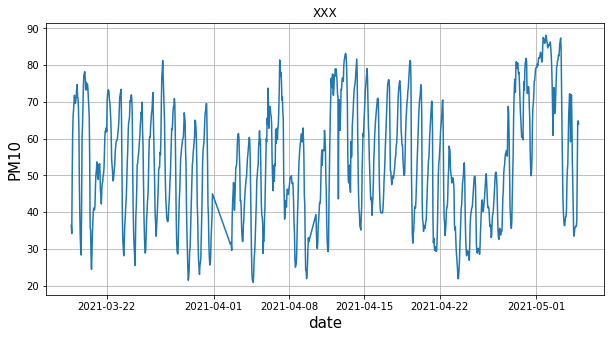

In [15]:
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(df_hourly.index,df_hourly["hum_pi"])

ax.set_xlabel('date', fontsize=15)
ax.set_ylabel('PM10', fontsize=15)
ax.set_title('XXX')

ax.grid(True)

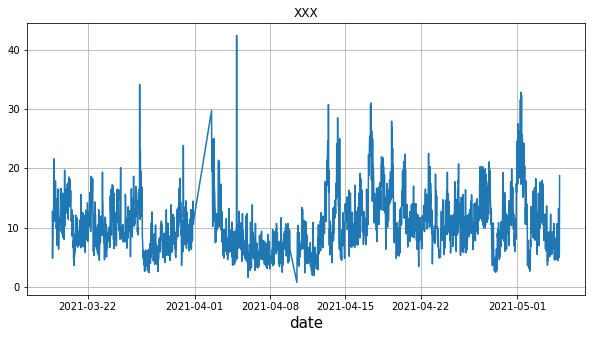

In [16]:
fig, ax = plt.subplots(figsize = (10,5))
plt.plot(df_30min.index,df_30min["PM2.5_pi"])

ax.set_xlabel('date', fontsize=15)
#ax.set_ylabel('PM10', fontsize=15)
ax.set_title('XXX')

ax.grid(True)